In [1]:
import string
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.porter import PorterStemmer
import re

def replace_urls(in_string, replacement=None):
   
    replacement = '<-URL->' if replacement is None else replacement
    pattern = re.compile('(https?://)?(\w*[.]\w+)+([/?=&]+\w+)*')
    return re.sub(pattern, replacement, in_string)


def tokenize_and_stem(doc):
    
    #split into words
    tokens = word_tokenize(doc)
    
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # remove words shorter than 4 char
    tokens = [word for word in tokens if len(word)>3]
    # handle URLS
    tokens = [replace_urls(w) for w in tokens]
    
    # stemming of words
    porter = PorterStemmer()
    tokens = [porter.stem(word) for word in tokens]

    return tokens

In [2]:
from pymongo import MongoClient
import gensim 
import pandas as pd  
import numpy as np 


client = MongoClient('localhost', 27017)
db = client['']

tweets = pd.DataFrame(list(db[''].find()))

data = pd.DataFrame(columns=['Tweets'])
data['Tweets'] = tweets['text']
data['Id'] = tweets['_id']
data['len']  = np.array([len(tweet) for tweet in data['Tweets']])
user = list()
for i in range(0,len(tweets)):
    user.append(tweets['user'][i]['name'])
data['user'] = np.array(user)

In [4]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

docs = data['Tweets']

tagged_data = [TaggedDocument(words=tokenize_and_stem(_d), tags=[str(i)]) for i, _d in enumerate(docs)]

In [6]:
print(tagged_data[:1])

[TaggedDocument(words=['ciao', 'ragazzi', 'dopo', 'tanto', 'tempo', 'torno', 'fort', 'inizieremo', 'questo', 'week', 'postar', 'pronostici', 'vincer', 'presto', 'mister'], tags=['0'])]


![title](img/W2V_D2V.png)


In [7]:
#train model

In [12]:
model = Doc2Vec(vector_size=100, dbow_words= 1, dm=0,  window=5, seed=1337, min_count=5, workers=4,alpha=0.025, min_alpha=0.025)
model.build_vocab(tagged_data)
for epoch in range(10):
    print("epoch "+str(epoch))
    model.train(tagged_data, total_examples=len(tagged_data), epochs=1)
    model.alpha -= 0.002  # decrease the learning rate
    model.min_alpha = model.alpha  # fix the learning rate, no decay

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9


In [13]:
model.save("d2v.model")
print("Model Saved")

Model Saved


In [14]:
print(model)

Doc2Vec(dbow+w,d100,n5,w5,mc5,s0.001,t4)


In [15]:
X = model[model.wv.vocab]

In [ ]:
#Kmeans

Counter({0: 2534, 2: 1105, 5: 1029, 4: 934, 1: 649, 3: 182})
silhouette score:  0.17042679


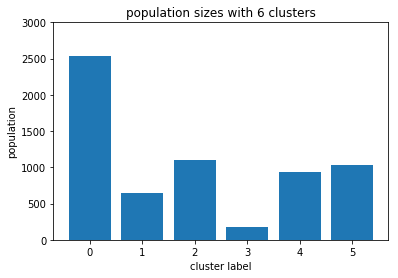

In [21]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import collections
 
k=6

kmeans = KMeans(n_clusters=k)
kmeans.fit(X)
 
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
  
silhouette_score = silhouette_score(X, labels, metric='euclidean')

plt.bar(range(len(set(labels))), np.bincount(labels))

plt.ylabel('population')
plt.xlabel('cluster label')
plt.title('population sizes with {} clusters'.format(k));

# truncate y axis to see the rest better
plt.ylim(0,3000);

print (collections.Counter(labels))
print ('silhouette score: ', silhouette_score)